## Auto1 - Data Challenge

# Questions:
1. List as many use cases for the dataset as possible.
2. Pick one of the use cases you listed in question 1 and describe how building a statistical model based on the dataset could best be used to improve Auto1’s business.
3. Implement the model you described in question 2 in R or Python.
4. Explain each and every of your design choices. Describe how you would improve the model in Question 3 if you had more time.

### Question 1:
Quickly, the cases that I can think of given the dataset would be:
1. Quick and easy grouping by car characteristics to see what are the biggest groups, meaning the most common cars
2. Clustering, specially to find what are the characteristics that give a high or low value to a car. Same for the symboling value
3. Predictive model for car's price
4. Predictive model for insurance symboling
5. Predictive model for normalized losses (find what cars lose or maintain their value)

### Question 2:
I think that in the case of Auto1 cases 2 or 3 are the most relevant for Auto1's business. I will specifically focus on case 3.

Given that Auto1 deals with used cars, the goal is to optimize the profit margin, i.e. buy cheapest and sell the highest possible. A predictive model will obviously help at that, as if one have an estimate of for how much a car can be sold, the purchase price will come automatically from it given a certain profit that has to be maintained.

This also would avoid situations where a car is bought for more than it can be sold reducing the risk of loses because of a bad deal.

On the other hand, if the predictive model included location, it would be possible not only to have an estimate of the possible selling price, but find the locations with the highest selling prices for a given type of car and the places where they are sold the cheapest, optiming further the profit.

### Question 3:
Python implementation of a simple predictive model based on Random Forest

*Requierements*
- Python == 3.5.2
- Numpy == 1.11.3
- Pandas == 0.19.2
- Matplotlib == 1.5.1
- scikit-learn==0.18.1

In [47]:
%matplotlib inline

In [48]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [49]:
%cd ../data/input/

[Errno 2] No such file or directory: '../data/input/'
/Users/inko/Documents/new_job/home_tasks/Auto1/data/input


In [127]:
# Basic class wrapper around Scikit-Learn RandomForest for convinience
class PricePredictor(RandomForestRegressor):
    
    def __init__(self, n_estimators=50, max_features=3):
        self.model = RandomForestRegressor(n_estimators=n_estimators,
                                           max_features=max_features)
        
    def fit(self, X, y):
        self.model = self.model.fit(X, y)
        
    def predict(self, X):
        return self.model.predict(X)
    
    def labelize(self, labels, dataset):
        self.labels_encoder = {}
        
        d = dataset.copy()
        for label in labels:
            self.labels_encoder[label] = LabelEncoder()
            self.labels_encoder[label].fit(d[label])
            d[label] = label_encoders[label].transform(d[label])
        
        return d

In [23]:
dataset_filename = "Auto1-DS-TestData_nan.csv"

In [24]:
raw_dataset = pd.read_csv(dataset_filename)

In [25]:
raw_dataset.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


In [26]:
raw_dataset.shape

(205, 26)

In [27]:
raw_dataset.columns

Index(['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration',
       'num-of-doors', 'body-style', 'drive-wheels', 'engine-location',
       'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type',
       'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke',
       'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg',
       'highway-mpg', 'price'],
      dtype='object')

In [128]:
# Checking combinations of body-style and driving wheels as some types of cars tend to prefer one or the other
raw_dataset.groupby(["body-style", "drive-wheels"]).size()

body-style   drive-wheels
convertible  fwd              1
             rwd              5
hardtop      fwd              1
             rwd              7
hatchback    4wd              2
             fwd             49
             rwd             19
sedan        4wd              3
             fwd             57
             rwd             36
wagon        4wd              4
             fwd             12
             rwd              9
dtype: int64

In [29]:
# Similar to above but with engine location. As there are only 3 samples or rwd rear, can ignore this field
raw_dataset.groupby(["drive-wheels", "engine-location"]).size()

drive-wheels  engine-location
4wd           front                9
fwd           front              120
rwd           front               73
              rear                 3
dtype: int64

In [30]:
# Given that also their price is in the top percentiles, no much harm by ignoring this feature
raw_dataset[raw_dataset["engine-location"]=="rear"].price

126    32528.0
127    34028.0
128    37028.0
Name: price, dtype: float64

In [31]:
raw_dataset[raw_dataset["engine-location"]!="rear"].price.describe()

count      198.000000
mean     12884.085859
std       7552.278510
min       5118.000000
25%       7775.000000
50%      10221.500000
75%      16322.000000
max      45400.000000
Name: price, dtype: float64

In [118]:
# Working data set to avoid having to reload it from the file for every transformation or test
dataset = raw_dataset.loc[:, ['make', 'fuel-type', 'aspiration', 'num-of-doors',
                              'body-style', 'drive-wheels', 'length', 'width', 'height',
                              'curb-weight', 'engine-type', 'num-of-cylinders',
                              'engine-size', 'fuel-system', 'horsepower',
                              'peak-rpm', 'city-mpg', 'highway-mpg', 'price']].copy()

In [119]:
dataset.shape

(205, 19)

In [120]:
# Droping NaNs only loses 8 cars, in this case acceptable
dataset = dataset.dropna()
dataset.shape

(197, 19)

In [121]:
dataset.price.describe()

count      197.000000
mean     13279.644670
std       8010.334218
min       5118.000000
25%       7775.000000
50%      10345.000000
75%      16503.000000
max      45400.000000
Name: price, dtype: float64

In [122]:
categories = ['make', 'fuel-type', 'aspiration', 'body-style', 'num-of-doors',
              'drive-wheels', 'num-of-cylinders', 'engine-type', 'fuel-system']

price_model = PricePredictor(25)
dataset = price_model.labelize(categories, dataset)

In [123]:
dataset.head()

,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,0,1,0,1,0,2,168.8,64.1,48.8,2548,0,2,130,5,111.0,5000.0,21,27,13495.0
1,0,1,0,1,0,2,168.8,64.1,48.8,2548,0,2,130,5,111.0,5000.0,21,27,16500.0
2,0,1,0,1,2,2,171.2,65.5,52.4,2823,4,3,152,5,154.0,5000.0,19,26,16500.0
3,1,1,0,0,3,1,176.6,66.2,54.3,2337,2,2,109,5,102.0,5500.0,24,30,13950.0
4,1,1,0,0,3,0,176.6,66.4,54.3,2824,2,1,136,5,115.0,5500.0,18,22,17450.0


In [124]:
x = dataset.copy().drop(["price"], axis=1)
y = dataset.copy().loc[:, ["price"]]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.4)

In [125]:
price_model.fit(X_train, y_train)
y_hat = price_model.predict(X_test)

/Users/inko/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


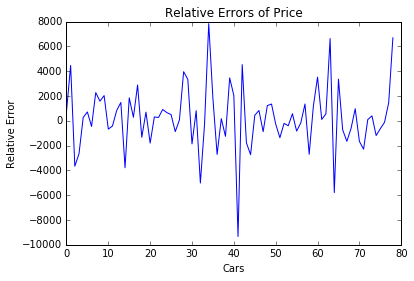

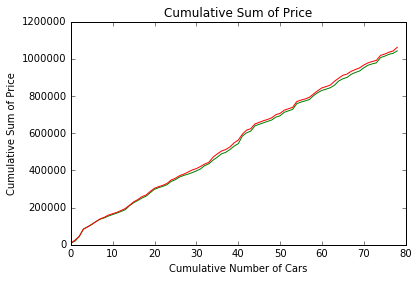

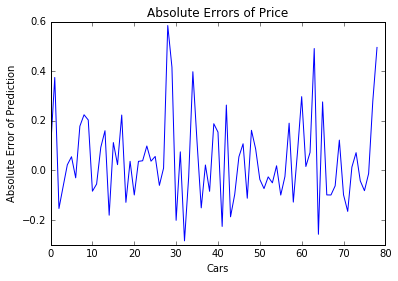

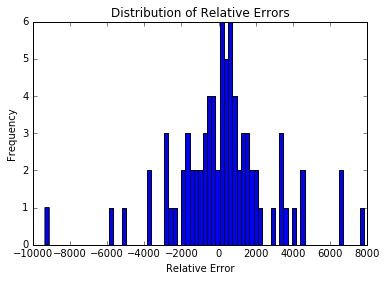

In [129]:
# Errors
r = y_test.copy()
r["y_hat"] = y_hat
r["relative_error"] = r.y_hat - r.price
r["absolute_error"] = r.relative_error / r.price
r["cum_error"] = r.relative_error.cumsum()

# Plotting
plt.title("Relative Errors of Price")
plt.xlabel("Cars")
plt.ylabel("Relative Error")
plt.plot(np.arange(r.shape[0]), r.relative_error)
plt.show()

plt.title("Cumulative Sum of Price")
plt.xlabel("Cumulative Number of Cars")
plt.ylabel("Cumulative Sum of Price")
plt.plot(np.arange(r.shape[0]), r.price.cumsum(), color="g")
plt.plot(np.arange(r.shape[0]), r.y_hat.cumsum(), color="r")
plt.show()

plt.title("Absolute Errors of Price")
plt.xlabel("Cars")
plt.ylabel("Absolute Error of Prediction")
plt.plot(np.arange(r.shape[0]), r.absolute_error)
plt.show()

# To check assumption that residuals are normally distributed
plt.title("Distribution of Relative Errors")
plt.xlabel("Relative Error")
plt.ylabel("Frequency")
plt.hist(r.relative_error, bins=75)
plt.show()

In [130]:
print("Mean relative error: %f" % r["relative_error"].mean())
print("Mean absolute error: %f" % r["absolute_error"].mean())

Mean relative error: 246.019916
Mean absolute error: 0.044742


## Question 4:

### Explain each and every of your design choices
Given that the problem at hand is a regression, there are some possible models to consider:
- Linear Regression
- Random Forest
- Neural Networks
- SVM

The last two (ANN, SVM) have more hyper-parameters or might need a kernel function, thus, due to limited time and small data set, it is not worth the effort.

Linear regression is an easy option but it also requires to make assumptions on feature dependency (linear, quadratic, etc.), not to mention that the features should be independent which is not generally the case with the features given. Also, because we have a mix of categorical and numerical data, we would need to transform the categorical data into a vector (one-hot encoding for example) creating even more features in a dataset with already 26 features but only 200 samples. 

In general, I tend to favor Random Forest. On one hand, because they are easy to have them working, have few hyper-parameters to tune and on the other, because in practice they have shown to have good results out of the box.

Because I already have a prototype of a wrapper around Scikit-Learn RandomForest, I decided to use it instead of directly using Scikit-Learn's one. The idea of the wrapper is to have added functionally that generally is good to have such as pickle/unpickle trained models, import/export training data, data set transformations, model scoring, plot functions, etc.

Because of the small data set, I decided to reduce the number of features to the minimum possible, so I just took the ones that I thought are generally driving the price of cars, or at least the ones that people look at. For that reason directly dropped symboling and normalized losses and the more technical motor properties.

Next I analyzed the distribution of car type, drive wheels and power transmission. Generally sport cars tend to have front motor with rear wheel transmission, sedans front motor and fwd, etc. Given the combinations, I decided to only remove drive-wheels as there are only 3 samples. I also removed wheelbase because generally the length of the car is more relevant.

Initially I was thinking on doing a K-Fold cross-validation due to the small sample size instead of train-test split, but after playing a bit manually with the number of trees and split, didn't make much sense to go that route since in few tries the model quickly got to what seems to be its best performance, so I decided to just leave it with a simple split.

The reason why I chose 25 trees and a 60-40 split is as I said, because it seems to give the best fit. I tried 25, 50 and 75 trees and 0.4 and 0.2 for the training-test split.

With 25 and 0.4 seems to be one of the best combinations. Clearly, with such a small data set, a big split and few trees avoids overfitting, as expected. With a bigger training set of more trees, the test predictions decay very fast.

Generally I would look at the RMS, average (or median) individual error or Pearson correlation coefficient, but again, given the time limitation, small data set and that there is really no need for optimization, a simple look at the errors I think is enough to evaluate the model.

Of course making sure that the errors are normally distributed, that more or less do given the small sample, is important and that's why the graph is there. The other three graphs at the top are just a quick visual reference of the model fit without having to calculate any other score. 

### Describe how you would improve the model in Question 3 if you had more time.
The first thing that I would look at is the correlation between features. There are features that are defenitely correlated. For example, diesel cars tend to be heavier, have better mpgs and longer strokes than gas engines. Turbo cars have more power and as I mentioned earlier, some types of cars tend to have associated some wheel drive, motor location, turbo, etc. For example sport cars will tend to be turbo, rwd, with higher power, worse mpg and more expensive, also they tend to have convertible versions. Length and wheelbase and type of car (hatchbag has a more equal wheelbase to length than a sedan for example, etc.) are another two features that can be closely correlated for example.

So the next thing that I would do is look at the correlation matrix and may be even try a correlation matrix clustering to further reduce the number of features.

I would also explore linear regression as an alternative to Random Forest. Once the baseline is achieved with a naive Random Forest model, it is easier to know what score to beat and optimize from there.

A further step of course is to find a better fit for the Random Forest than manually setting the number of trees and split, so I would do a K-Fold cross-validation to optimize the hyper-parameters in the Random Forest.

Finally, I would look at those cars with a big error. My bet is that those are the rare cases, rwd, 4wd, turbo, etc. An alternative to improve the predictive accuracy could be to add more of those into the dataset to balance the "classes".